### Импорты

In [1]:
import pickle
import math
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import gzip
import sys
import msgpack
# !{sys.executable} -m pip install msgpack

### Функции

In [2]:
coord = [1843.5, 1625.5, 1401.5, 1184, 964.5, 741.5, 518.5, 302.5]


def clean(events, p): # удаление из массива заданных номеров
    for i in range(-1, -len(p) - 1, -1):
        events.pop(p[i])
    return events


def is_event(a, b, c, d): # проверка комбинаций проволок на возможность быть событием
    if (a == b - 1 == c - 2 == d - 3) and a % 4 == 0:
        return 1, 4
    else:
        if (a % 4 == 0 or a % 4 == 1) and (a < b < c < a // 2 + 4): # первая или вторая проволока камеры + крайняя проволока не попадает в следующую камеру
            return 1, 3
        else:
            return 0, 0
        

def mnk(x, y): # отклонение точек от аппроксимационной прямой + k и b
    xy = [x[i] * y[i] for i in range(len(x))]
    x2 = [x[i] ** 2 for i in range(len(x))]
    
    k = (len(x) * sum(xy) - sum(x) * sum(y)) / (len(x) * sum(x2) - sum(x) ** 2)
    b = (sum(y) - k * sum(x)) / len(x)
    
    if b > 0:
        mu = -1 / ((k ** 2 + 1) ** 0.5)
    else:
        mu = 1 / ((k ** 2 + 1) ** 0.5)
    
    sum_delta = 0
    for i in range(len(x)):
        sum_delta += (abs(mu * (k * x[i] - y[i] + b)))
    
    return [sum_delta, k, b]


def velocity(w): # скорость дрейфа в камерах
    if 0 <= w <= 3:
        v = 0.04370
    elif 4 <= w <= 7:
        v = 0.04385
    elif 8 <= w <= 11:
        v = 0.04370
    elif 12 <= w <= 15:
        v = 0.04370
    elif 16 <= w <= 19:
        v = 0.04438
    elif 20 <= w <= 23:
        v = 0.04438
    elif 24 <= w <= 27:
        v = 0.04438
    else:
        v = 0.04438
    return v


def teta(event): # тангенс угла наклона трека и свободный член
    global coord
    x = []
    y = []
    for k in range(0, len(event) - 1, 2):
        x.append(event[k + 1])
        y.append(coord[event[0] // 4] + 30 - event[k] % 4 * 10)
    m = mnk(y, x)
    return [1 / m[1], -m[2] / m[1]]


def oposite(event): # поиск противоположного трека к заданному
    for k in range(1, len(event), 2):
        if event[k - 1] % 2 == 0:
            event[k] = -(event[k] + 0.75) - 0.75
        else:
            event[k] = -(event[k] - 0.75) + 0.75
    return event, teta(event)


def sgn(x): # sgn
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0


def the_nearest_track(event, base_teta): # выбор точек трека в тестируемой камере, которые ближе всего находятся к опорному треку
    global coord
    y = coord[event[0] // 4]
    sign_changes = 0
    for i in range(1, len(event), 2):
        if event[i - 1] % 2 == 0:
            x_op = -(event[i] + 0.75) - 0.75
        else:
            x_op = -(event[i] - 0.75) + 0.75
        d_1 = abs((y + 30 - 10 * (event[i - 1] % 4) - base_teta[1]) / base_teta[0] - event[i])
        d_2 = abs((y + 30 - 10 * (event[i - 1] % 4) - base_teta[1]) / base_teta[0] - x_op)
        if d_2 < d_1:
            if sign_changes == 0:
                event[i] = x_op
                if i > 1:
                    if sgn(event[i]) != sgn(event[i - 2]):
                        sign_changes = 1
            else:
                if sgn(event[i - 2]) == -1:
                    event[i] = x_op
    return event


def the_best_track(event): # реконструкция события
    global coord
    for j in range(len(event)):
        for k in range(1, len(event[j]), 2):
            event[j][k] *= velocity(event[j][0])
            if event[j][k - 1] % 2 == 0:
                event[j][k] -= 0.75
            else:
                event[j][k] += 0.75
    event_copy = [event[j][:] for j in range(len(event))]
    best_track = [event[j][:] for j in range(len(event))]
    kb_0 = teta(event[0])
    kb_7 = teta(event[-1])
    y_0 = coord[0] + 15
    y_7 = coord[-1] + 15
    k = (y_0 - y_7) / ((y_0 - kb_0[1]) / kb_0[0] - (y_7 - kb_7[1]) / kb_7[0])
    b = y_0 - k * (y_0 - kb_0[1]) / kb_0[0]
    base_teta = [k, b] # рассчитанные опорные параметры прямой
    N = 4
    min_s = 501 * 8 * 4
    for q in range(N):
        if q % 2 == 0:
            event[0], kb_0 = oposite(event[0])
        else:
            event[-1], kb_7 = oposite(event[-1])
        k = (y_0 - y_7) / ((y_0 - kb_0[1]) / kb_0[0] - (y_7 - kb_7[1]) / kb_7[0])
        b = y_0 - k * (y_0 - kb_0[1]) / kb_0[0]
        base_teta = [k, b]
        
        for j in range(1, len(event) - 1):
            event[j] = event_copy[j][:]
        
        for j in range(1, len(event) - 1):
            event[j] = the_nearest_track(event[j], base_teta)
        s = 0
        for j in range(len(event)):
            for k in range(1, len(event[j]), 2):
                s += abs((coord[event[j][k - 1] // 4] + 30 - 10 * (event[j][k - 1] % 4) - base_teta[1]) / base_teta[0] - event[j][k])
        
        if s < min_s:
            best_track = [event[j][:] for j in range(len(event))]
            min_s = s
    return best_track


def show_zone_characteristics(zone, zone_char, type_of_char, show_distribution_point=1): # определение зонных характеристик и вывод графиков на экран
#     plt.rcParams["font.family"] = "serif"
#     plt.rcParams["font.serif"] = ["Times New Roman"]
    for i in range(len(zone)):
        for j in range(len(zone[i])):
            s = 0
            n = len(zone[i][j])
            try:
                m = sum(zone[i][j]) / n
                for k in range(len(zone[i][j])):
                    s += (zone[i][j][k] - m) ** 2
            except:
                s = 0
                n = 1
            zone_char[i][j] = (s / n) ** 0.5

    if show_distribution_point == 1:
        for i in range(type_of_char, len(zone) - type_of_char):
            for j in range(len(zone[i])):
                if j < 25:
                    plt.title(str(i) + " камера, " + str(j - 25) + " отрезок")
                else:
                    plt.title(str(i) + " камера, " + str(j - 24) + " отрезок")
                if type_of_char == 1:
                    plt.xlabel("$\\delta x, мм$")
                else:
                    plt.xlabel("$\\delta \Theta, град$")
                plt.ylabel("Кол-во событий")
                plt.hist(zone[i][j], np.arange(-20, 20, 0.5))
                plt.show()
    for i in range(type_of_char, len(zone_char) - type_of_char):
        x = []
        err = []
        for j in range(len(zone_char[i])):
            if j - 25 < 0:
                x.append(j - 25)
            else:
                x.append(j - 24)
            if len(zone[i][j]) != 0:
                err.append((zone_char[i][j] / len(zone[i][j])) ** 0.5)
            else:
                err.append(0)
        plt.title(str(8 - i) + " камера")
        plt.xlabel("x, см")
        if type_of_char == 1:
            plt.ylabel("$\\sigma, мм$")
        else:
            plt.ylabel("$\\sigma, град$")
#         plt.axis([-26, 26, 0, max(zone_char[i]) + max(err) + 0.1])
        plt.axis([-26, 26, 0, 5])
        plt.errorbar(x, zone_char[i], yerr = err, fmt='.', ecolor='red', capsize=2)
        plt.show()

### Чтение файлов .gz

In [33]:
%%time
def get_path_to_data_files(path):
    files = []
    if os.path.isdir(path):
        for path, dirs, file_names in os.walk(path):
            files.extend(file_names)
    files = sorted(files, key=lambda d: d)
    return ["{}/{}".format(path, file) for file in files]


def read_file(path_to_file):
    file = gzip.open('{}'.format(path_to_file), 'rb')
# unpacker = msgpack.Unpacker(file, encoding='utf-8')
    unpacker = msgpack.Unpacker(file)
    unpacked_data = [unpack for unpack in unpacker]
    file.close()
    return unpacked_data

# "~/НЕВОД_прога/jupyter/Данные Стенд ДК/run_61"
run_61_path = os.path.join("Данные Стенд ДК", "run_61")
path_to_data_file = get_path_to_data_files(run_61_path)
# records = read_file(path_to_data_file[0])
useful_data = []
for i in range(len(path_to_data_file)):
    for records in read_file(path_to_data_file[i]):
        for record in records:
            for sg in record["signals"]:
                ch = sg["ch"] // 4
                wire = 3 - sg["ch"] % 4
                leading = sg["l_e"]
                trailing = sg["t_e"]
        # useful_data = []
        # for i in range(len(records)):
        #     useful_data.append([])
        #     for j in range(len(records[i]['signals'])):
        #         useful_data[i].append(records[i]['signals'][j]['ch'])
        #         useful_data[i].append(records[i]['signals'][j]['l_e'])
        try:
            useful_data.append(sum([sum([[records[i]['signals'][j]['ch'], records[i]['signals'][j]['l_e']]], []) for j in range(len(records[i]['signals'])) for i in range(len(records))]), [])
        except:
            [sum([records[k]['signals'][j]['ch'], records[k]['signals'][j]['l_e']], []) for j in range(len(records[k]['signals'])) for k in range(len(records))]

print(len(useful_data))

TypeError: string indices must be integers

In [26]:
a = sum([sum([[0, x + 1]], [])[:] for x in range(1, 3)], [])
print(a)

[0, 2, 0, 3]


In [6]:
def velocity(w): # скорость дрейфа в камерах
    if 0 <= w <= 3:
        v = 0.04480
    elif 4 <= w <= 7:
        v = 0.04240
    elif 8 <= w <= 11:
        v = 0.04240
    elif 12 <= w <= 15:
        v = 0.04300
    elif 16 <= w <= 19:
        v = 0.04509
    elif 20 <= w <= 23:
        v = 0.04500
    elif 24 <= w <= 27:
        v = 0.04582
    else:
        v = 0.04438
    return v

#### Скорости дрейфа
RUN: RUN_61
скорости для каждой камеры:  
камера_0: 0.04480  
камера_1: 0.04240  
камера_2: 0.04240  
камера_3: 0.04370  
камера_4: 0.04509  
камера_5: 0.04582  
камера_6: 0.04582  
камера_7: 0.04438  

### Разбиение событий

In [4]:
%%time
try:
    useful_data
except:
    with open("save.bin", 'rb') as l:
        useful_data = pickle.load(l)

p = []
for i in range(len(useful_data)):
    if len(useful_data[i]) > 96:
        p.append(i)
useful_data = clean(useful_data, p)

for i in range(len(useful_data)):
    p = []
    for j in range(2, len(useful_data[i]), 2):
        if useful_data[i][j - 2] == useful_data[i][j]: # если две соседние проволоки повторяются -> убрать вторую
            p.append(j)
            p.append(j + 1)
    useful_data[i] = clean(useful_data[i], p)

events = []
for i in range(len(useful_data)):
    j = 0
    events.append([])
    while j < len(useful_data[i]) - 6:
        is_ev, count = is_event(useful_data[i][j], useful_data[i][j + 2], useful_data[i][j + 4], useful_data[i][j + 6])
        if is_ev == 1:
            if count == 4:
                events[i].append(useful_data[i][j:j+8])
                j += 8
            else:
                events[i].append(useful_data[i][j:j+6])
                j += 6
        else:
            j += 2

p = []
for i in range(len(events)):
    try:
        if len(events[i][0]) != 8 or len(events[i][-1]) != 8 or events[i][0][0] != 0 or events[i][-1][0] != 28:
            p.append(i)
    except:
        p.append(i)
events = clean(events, p)
print(len(events))
del useful_data
del p

6811
CPU times: user 222 ms, sys: 3.14 ms, total: 225 ms
Wall time: 223 ms


### Offset

In [5]:
%%time
offset = 6500
for i in range(len(events)):
    for j in range(len(events[i])):
        for k in range(1, len(events[i][j]), 2):
            events[i][j][k] = offset - 5 * events[i][j][k]

p = []
for i in range(len(events)):
    c = 0
    for j in range(len(events[i])):
        for k in range(1, len(events[i][j]), 2):
            if events[i][j][k] < 0:
                p.append(i)
                c = 1
                break
        if c == 1:
            break
events = clean(events, p)

print(len(events))
del p

6806
CPU times: user 148 ms, sys: 4.9 ms, total: 153 ms
Wall time: 152 ms


### Реконструкция треков

In [6]:
%%time
base_teta = []
y_0 = coord[0] + 15
y_7 = coord[7] + 15
kb = []
for i in range(len(events)):
    events[i] = the_best_track(events[i])
    base_teta.append([])
    kb_0 = teta(events[i][0])
    kb_7 = teta(events[i][-1])
    k = (y_0 - y_7) / ((y_0 - kb_0[1]) / kb_0[0] - (y_7 - kb_7[1]) / kb_7[0])
    b = y_0 - k * (y_0 - kb_0[1]) / kb_0[0]
    base_teta[i] = [k, b]
    kb.append([])
    kb[i] = [[] for i in range(8)]
    for j in range(len(events[i])):
        kb[i][events[i][j][0] // 4] = teta(events[i][j])

CPU times: user 1.76 s, sys: 5.85 ms, total: 1.76 s
Wall time: 1.77 s


### Корректировка событий с лишней точкой

In [10]:
%%time
for i in range(len(events)):
    for j in range(1, len(events[i]) - 1):
        if len(events[i][j]) == 8:
            dx_max = 0
            p = -1
            for k in range(1, len(events[i][j]), 2):
                dx = abs((coord[events[i][j][k - 1] // 4] + 30 - events[i][j][k - 1] % 4 * 10 - base_teta[i][1]) / base_teta[i][1] - events[i][j][k])
                if dx > dx_max:
                    dx_max = dx
                    p = k -1
            count = 0
            for k in range(1, len(events[i][j]), 2):
                if dx_max - abs((coord[events[i][j][k - 1] // 4] + 30 - events[i][j][k - 1] % 4 * 10 - base_teta[i][1]) / base_teta[i][1] - events[i][j][k]) >= 4:
                    count += 1
            if count == 3:
                events[i][j].pop(p)
                events[i][j].pop(p)
            try:
                kb[i][events[i][j][0] // 4] = teta(events[i][j])
            except:
                pass

CPU times: user 527 ms, sys: 2.61 ms, total: 529 ms
Wall time: 528 ms


### Удаление плохих событий

In [11]:
%%time
p = []
for i in range(len(events)):
    dx = 0
    for j in range(len(events[i])):
        dx = 0
        for k in range(1, len(events[i][j]), 2):
            dx += abs((coord[events[i][j][k - 1] // 4] + 30 - events[i][j][k - 1] % 4 * 10 - base_teta[i][1]) / base_teta[i][0] - events[i][j][k])
        if dx > 60:
            p.append(i)
            break
events = clean(events, p)
kb = clean(kb, p)
base_teta = clean(base_teta, p)

p = []
for i in range(len(events)):
    for j in range(len(events[i])):
        c = 0
        for k in range(1, len(events[i][j]), 2):
            if abs(events[i][j][k]) > 250:
                p.append(i)
                c = 1
                break
        if c == 1:
            break
events = clean(events, p)
kb = clean(kb, p)
base_teta = clean(base_teta, p)
print(len(events))
del p

4494
CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 247 ms


#### Backup

In [12]:
with open("backup_e.bin", 'wb') as l:
    pickle.dump(events, l)
with open("backup_k.bin", 'wb') as l:
    pickle.dump(kb, l)
with open("backup_base.bin", 'wb') as l:
    pickle.dump(base_teta, l)

## Повороты камер

#### Обновление данных в массивах

In [21]:
%%time
with open("backup_e.bin", 'rb') as l:
    events = pickle.load(l)
with open("backup_k.bin", 'rb') as l:
    kb = pickle.load(l)
with open("backup_base.bin", 'rb') as l:
    base_teta = pickle.load(l)

CPU times: total: 125 ms
Wall time: 148 ms


In [16]:
%%time
def rotate(chamber, axis, angle, events, kb):
    global coord
    if axis == "x":
        for i in range(len(events)):
            x = []
            y = []
            for j in range(1, len(events[i]) - 1):
                if len(events[i][j]) != 0:
                    if events[i][j][0] // 4 == chamber:                    
                        x_1 = [events[i][j][k] for k in range(1, len(events[i][j]), 2)]
                        y_1 = [36 + 30 - events[i][j][k] % 4 * 10 for k in range(0, len(events[i][j]) - 1, 2)]
                        x = [x_1[i] * math.cos(angle) - y_1[i] * math.sin(angle) for i in range(len(x_1))]
                        y = [coord[chamber] + x_1[i] * math.sin(angle) + y_1[i] * math.cos(angle) - 36 for i in range(len(x_1))]
                        
                        m = mnk(y, x)
                        m = [1 / m[1], -m[2] / m[1]]

                        for k in range(1, len(events[i][j]), 2):
                            events[i][j][k] = (coord[chamber] + 30 - events[i][j][k - 1] % 4 * 10 - m[1]) / m[0]
                        kb[i][events[i][j][0] // 4] = m[:]
                        break
    return events, kb

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
# events, kb = rotate(1, "x", math.radians(-2), events, kb)
# events, kb = rotate(2, "x", math.radians(1), events, kb)
# events, kb = rotate(3, "x", math.radians(-0.1), events, kb)
# events, kb = rotate(4, "x", math.radians(-0.1), events, kb)
# events, kb = rotate(5, "x", math.radians(-0.1), events, kb)
# events, kb = rotate(6, "x", math.radians(2.6), events, kb)

In [17]:
events, kb = rotate(1, "x", math.radians(-2), events, kb)
events, kb = rotate(2, "x", math.radians(-0.3), events, kb)
events, kb = rotate(6, "x", math.radians(-0.1), events, kb)

#### Минимизация отклонений координат трека в тестируемой камере от координат, посчитанных по опорным камерам, с помощью поворотов

In [13]:
%%time
with open("backup_e.bin", 'rb') as l:
    events = pickle.load(l)
with open("backup_k.bin", 'rb') as l:
    kb = pickle.load(l)
with open("backup_base.bin", 'rb') as l:
    base_teta = pickle.load(l)


for chamber in range(1, 7):
    d_min = 500 * 4
    teta = 0
    try:
        for alpha in tqdm(np.arange(-3, 3, 0.1)):
            ev, _ = rotate(chamber, "x", math.radians(alpha), events, kb) # повёрнутый массив
            bt = [base_teta[i][:] for i in range(len(base_teta))]
            events_c = []
            p = []
            for i in range(len(ev)):
                c = 0
                for j in range(len(ev[i])):
                    if len(ev[i][j]) != 0:
                        if ev[i][j][0] // 4 == chamber:
                            events_c.append(ev[i][j][1::2])
                            c = 1
                if c == 0:
                    p.append(i)

            bt = clean(bt, p)
            p = []
            for i in range(len(events_c)):
                for j in range(len(events_c[i])):
                    if abs(events_c[i][j]) >= 250:
                        p.append(i)
                        break
            events_c = clean(events_c, p)
            bt = clean(bt, p)
            s = sum([(abs(coord[j] + 30 - 10 * k - bt[i][1]) / bt[i][0] - events_c[i][k]) for i in range(len(events_c)) for k in range(len(events_c[i]))]) / len(events_c)
            if s < d_min:
                d_min = s
                teta = alpha
        print(chamber, teta)
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.01it/s]


1 -1.899999999999999


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.80it/s]


2 -0.2999999999999976


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.63it/s]


3 2.6645352591003757e-15


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.98it/s]


5 2.6645352591003757e-15


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.53it/s]

6 -0.09999999999999742
CPU times: total: 30.8 s
Wall time: 30.8 s


#### Минимизация отклонений координат трека в тестируемой камере от координат, посчитанных по опорным камерам, с помощью изменения offsetа

In [ ]:
for offset in range(6400, 6500, 5):
    for i in range(len(events)):
        for j in range(len(events[i])):
            for k in range(1, len(events[i][j]), 2):
                events[i][j][k] = offset - 5 * events[i][j][k]
# надо подумать над оптимизацией

## Зонные характеристики

### Координатная точность

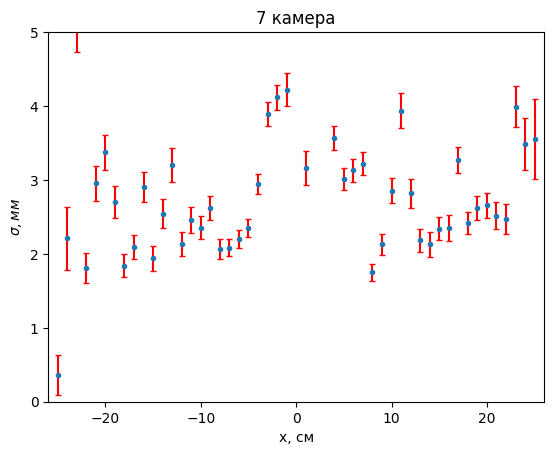

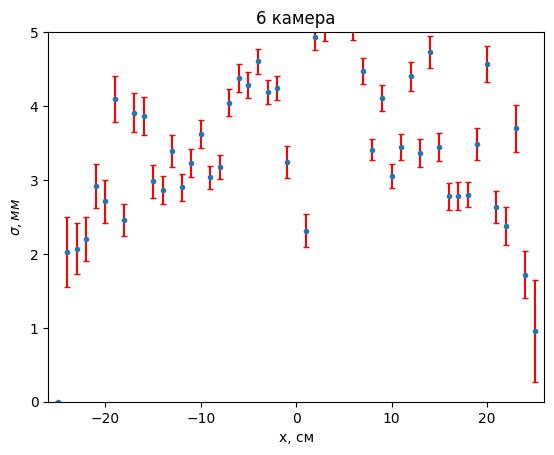

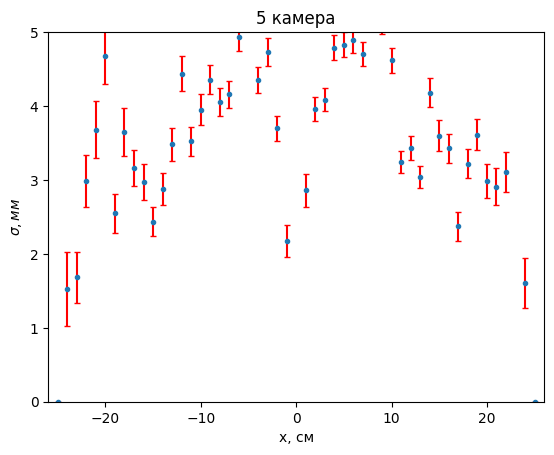

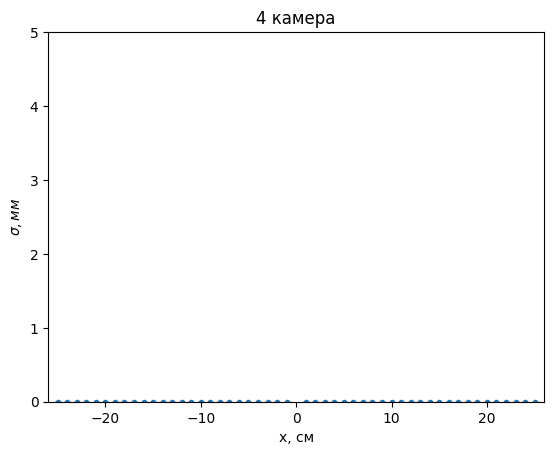

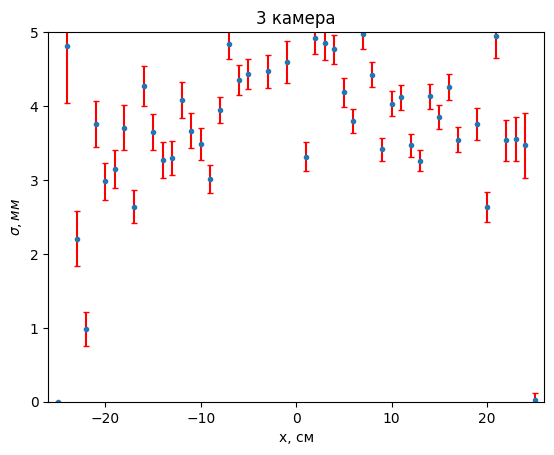

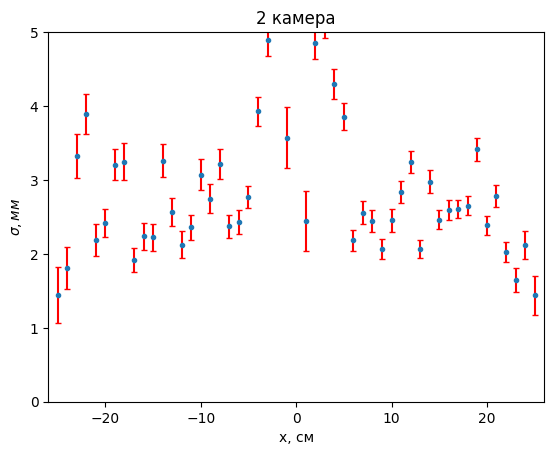

CPU times: user 1.07 s, sys: 819 ms, total: 1.89 s
Wall time: 955 ms


In [13]:
%%time
zone = [[[] for i in range(50)] for j in range(8)]
zone_char = [[0 for i in range(50)] for j in range(8)]

for i in range(len(events)):
    for j in range(len(events[i])):
        if len(events[i][j]) != 0:
            dx = (coord[events[i][j][0] // 4] + 15 - kb[i][events[i][j][0] // 4][1]) / kb[i][events[i][j][0] // 4][0] - (coord[events[i][j][0] // 4] + 15 - base_teta[i][1]) / base_teta[i][0]
            try:
                zone[events[i][j][0] // 4][int((coord[events[i][j][0] // 4] + 15 - kb[i][events[i][j][0] // 4][1]) / kb[i][events[i][j][0] // 4][0]) // 10 + 25].append(dx)
            except:
                print(events[i][j])

show_zone_characteristics(zone, zone_char, 1, show_distribution_point=0)

### Угловая точность

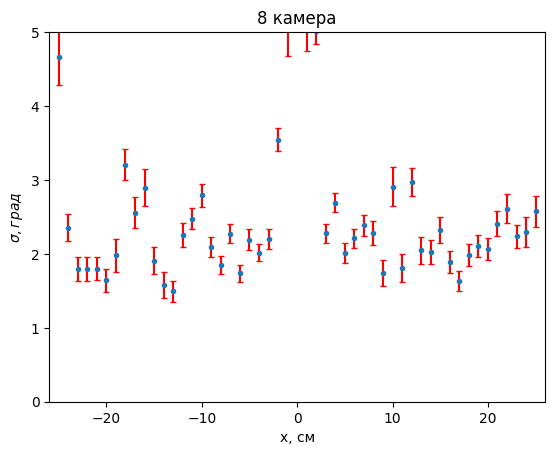

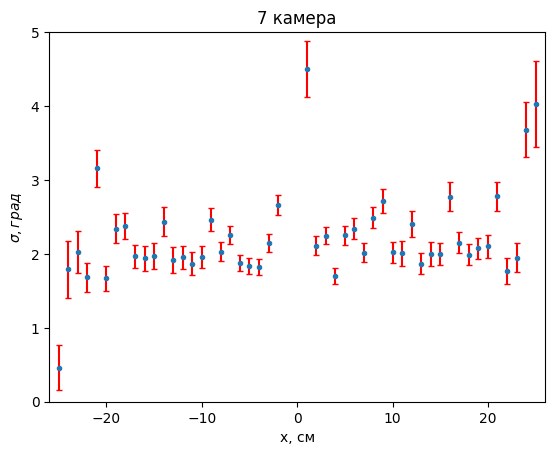

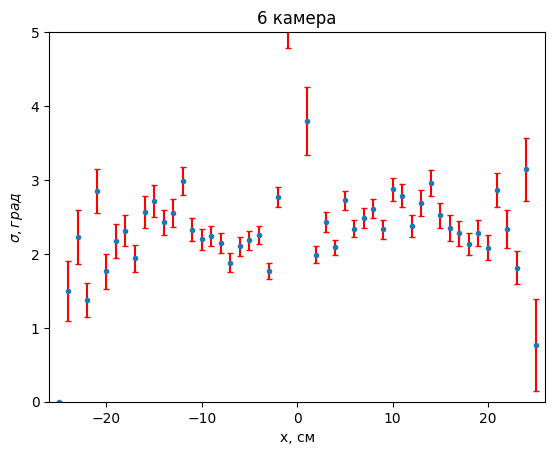

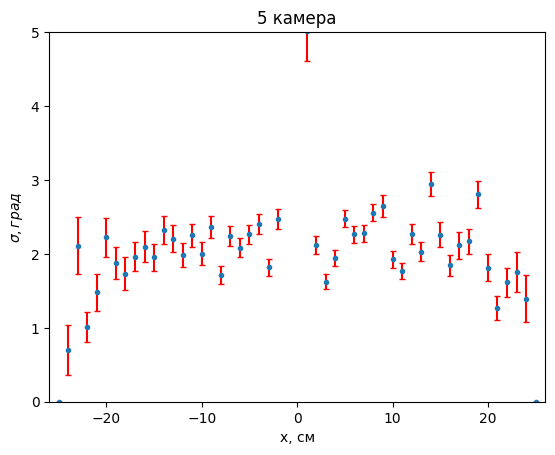

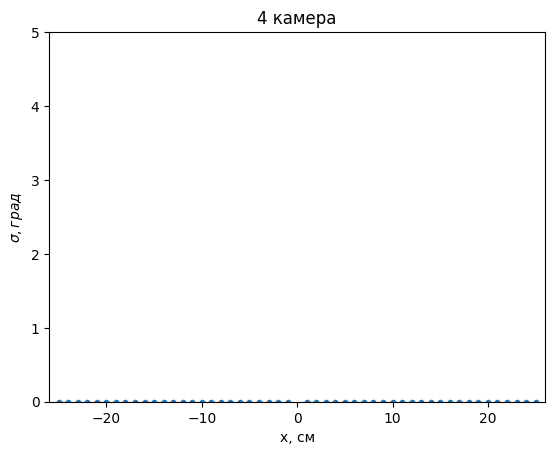

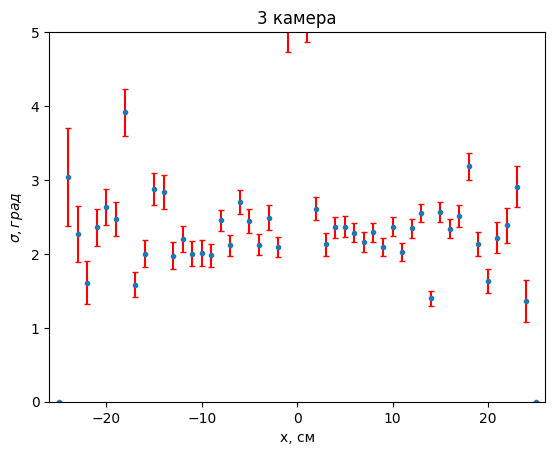

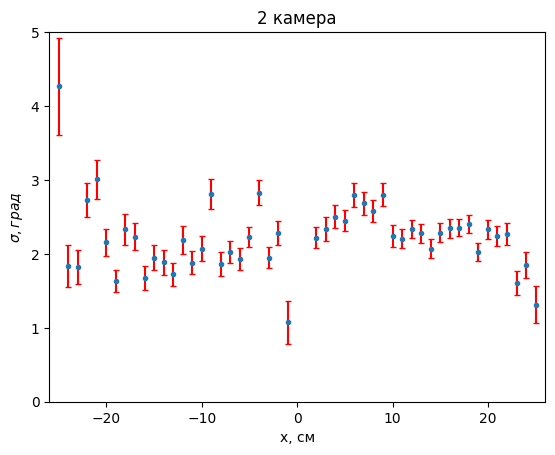

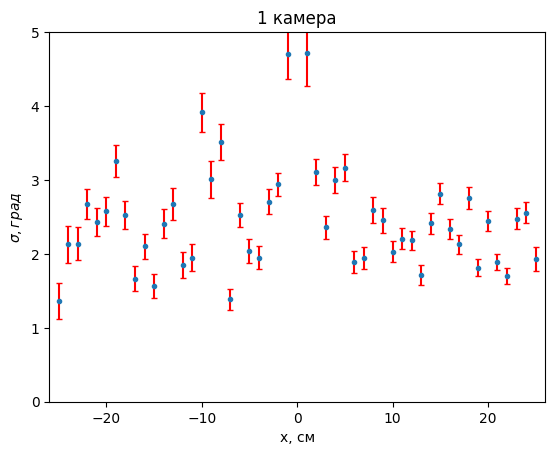

In [14]:
zone = [[[] for i in range(50)] for j in range(8)]
zone_char = [[0 for i in range(50)] for j in range(8)]

for i in range(len(events)):
    for j in range(len(events[i])):
        if len(events[i][j]) != 0:
            teta = math.degrees(math.atan(kb[i][events[i][j][0] // 4][0]))
            teta_th = math.degrees(math.atan(base_teta[i][0]))
            if teta_th > 0:
                teta_th = -(90 - teta_th)
            else:
                teta_th = -(-90 - teta_th)
            if teta > 0:
                teta = -(90 - teta)
            else:
                teta = -(-90 - teta)
            if abs(teta - teta_th) < 15:
                zone[events[i][j][0] // 4][int((coord[events[i][j][0] // 4] + 15 - kb[i][events[i][j][0] // 4][1]) / kb[i][events[i][j][0] // 4][0]) // 10 + 25].append(teta - teta_th)
    
show_zone_characteristics(zone, zone_char, 0, show_distribution_point=0)

### Запись массивов в файлы

In [14]:
%%time
# /home/egor/НЕВОД_прога/
path = os.path.join("~", "home", "egor", "НЕВОД_прога")
with open(os.path.join(path, "events.bin"), 'wb') as l:
    pickle.dump(events, l)
with open(os.path.join(path, "normal.bin"), 'wb') as l:
    pickle.dump(base_teta, l)
with open(os.path.join(path, "dt.bin"), 'wb') as l:
    pickle.dump(kb, l)
print(len(events))
# bred

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


##### Расширение экрана

In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

C:\Users\Egor\AppData\Local\Temp\ipykernel_6208\1574915380.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
